In [1]:
from sklearn import set_config
import AstroTools
import pandas as pd
import numpy as np
import sklearn

print('sklearn: {}'.format(sklearn.__version__))
print('Pandas Version: {}'.format(pd.__version__))
set_config(display='diagram')

path = AstroTools.Path()
AstroTools.ChangeFolder(path , '/Users/Andres/Documents/PhD/JPLUS_Code/Datasets/')

sklearn: 0.24.1
Pandas Version: 1.0.1
Last path:  /Users/Andres/Documents/PhD/JPLUS_Code/Scripts_and_Notebooks
New path is: /Users/Andres/Documents/PhD/JPLUS_Code/Datasets/


In [2]:
stellar = ['FLAG', 'SNR', 'SPECTYPE_SUBCLASS', 'Teff_GAIA',
           'TEFF_ADOP', 'LOGG_ADOP', 'FEH_ADOP', 'FEH_ANNRR',
           'TEFF_SPEC', 'LOGG_SPEC', 'FEH_SPEC']

#stellar = ['Teff_GAIA', 'subclass',
#           'teff', 'logg', 'feh']

def correctMags(df):
    
    Filters = list(AstroTools.Filters['JPLUS'])
    Correction = list(AstroTools.Filters['Ax'])
    #ID = AstroTools.Reference['Full']
    
    dfcp = pd.concat([df[a].sub(df[b]) for a, b in zip(Filters,Correction)],axis=1, keys=Filters).round(3)
    
    return dfcp
    
def add_id_columns(df1, df2, columns=AstroTools.Reference['Full']):
    
    df = df1.join(df2[columns])
    
    return df

def order_columns(df,reference=AstroTools.Reference['Full'],
                  filters=AstroTools.Filters['JPLUS']):
    
    return df[reference + filters]

def add_gaia_filters(df1, df2, columns=AstroTools.Filters['GAIA']):
    
    df = df1.join(df2[columns])
    
    return df

def add_wise_filters(df1, df2, columns=AstroTools.Filters['WISE']):
    
    df = df1.join(df2[columns])
    
    return df

def add_stellar_params(df1, df2, columns=stellar):
    
    df = df1.join(df2[columns])
    
    return df

def remove_contaminants(df):
    
    dfcp = df[df.SPECTYPE_SUBCLASS.str.contains('R|S|W') == False].copy()
#    dfcp = df[df.subclass.str.contains('R|S|W') == False].copy()
    
    return dfcp

def remove_bad_values(df, Column = ['SNR','TEFF_ADOP','LOGG_ADOP','FEH_ADOP']):
    
    cond0 = df[Column[0]].gt(10)
    cond1 = df[Column[1]].gt(-9999.0)
    cond2 = df[Column[2]].gt(-9999.0)
    cond3 = df[Column[3]].gt(-9999.0)
    allcond = cond0 & cond1 & cond2 & cond3
    return df[allcond].copy()

def remove_spec_subclasses(df):
    
    #df['SPECTYPE_SUBCLASS'] = df.SPECTYPE_SUBCLASS.map(lambda x: x.rstrip(r'(\d)'))
    df = df.assign(SPECTYPE_SUBCLASS = df.SPECTYPE_SUBCLASS.str.replace(r'(\d)', '')) # Replace Original Column
#    df = df.assign(SPECTYPE_SUBCLASS = df.subclass.str.replace(r'(\d)', '')) # Replace Original Column
    
    return df

def remove_bad_flags(df):
    
    dfcp = df[df.FLAG.str.contains('nnnnn') == True].copy()
    
    return dfcp

In [3]:
df = AstroTools.Read_Dataset('JPLUS_DR2/JPLUS_DR2_SSPP_SDSS_DR12_Bright_Sources.csv')
#df = AstroTools.Read_Dataset('idr202005/Training_Data_StellarParams_gold.csv')

Working_df_SSPP = (df.pipe(correctMags)            # MW Correction
                  .pipe(add_id_columns, df)       # Add TILE_ID, NUMBER, RA, DEC
                  .pipe(order_columns)            # Reorder columns
                  .pipe(add_gaia_filters, df)     # Add GAIA Filters
                  .pipe(add_wise_filters, df)     # Add WISE and 2MASS Filters
                  .pipe(add_stellar_params, df)   # Add TEFF_ADOP, FEH_ADOP, LOGG_ADOP to Dataframe
                  .pipe(remove_contaminants)      # Remove QSOs, BROADLINES, STARFORMING
                  .pipe(remove_bad_values)        # Remove -9999.0 values
                  .pipe(remove_spec_subclasses)
                  .pipe(remove_bad_flags)
                 )

Working_df_SSPP.dropna(inplace=True)
Working_df_SSPP.isnull().sum()

TILE_ID              0
NUMBER               0
RA                   0
DEC                  0
FWHM_WORLD           0
uJAVA                0
J0378                0
J0395                0
J0410                0
J0430                0
gSDSS                0
J0515                0
rSDSS                0
J0660                0
iSDSS                0
J0861                0
zSDSS                0
G                    0
BP                   0
RP                   0
W1                   0
W2                   0
W3                   0
W4                   0
J                    0
H                    0
K                    0
FLAG                 0
SNR                  0
SPECTYPE_SUBCLASS    0
Teff_GAIA            0
TEFF_ADOP            0
LOGG_ADOP            0
FEH_ADOP             0
FEH_ANNRR            0
TEFF_SPEC            0
LOGG_SPEC            0
FEH_SPEC             0
dtype: int64

In [4]:
Working_df_SSPP.FLAG.unique()

array(['nnnnn'], dtype=object)

In [5]:
Working_df_SSPP[['SNR', 'TEFF_ADOP', 'FEH_ADOP', 'FEH_ANNRR', 'LOGG_ADOP']].describe()

,SNR,TEFF_ADOP,FEH_ADOP,FEH_ANNRR,LOGG_ADOP
count,5733.000000,5733.000000,5733.000000,5733.000000,5733.000000
mean,53.737527,6081.229628,-0.807614,-0.825425,3.962438
std,13.467622,741.978096,0.656871,0.719689,0.419588
min,13.829967,4475.488300,-3.170351,-3.336990,0.648500
25%,44.144505,5555.629000,-1.263943,-1.329999,3.825078
50%,52.469720,5986.445300,-0.580081,-0.579972,4.042354
75%,61.541107,6320.335000,-0.342698,-0.322191,4.220918
max,128.917600,9166.306000,0.499071,0.610684,4.727269


In [6]:
from sklearn.base import TransformerMixin

class FeaturesSelection(TransformerMixin):   # Create custom transformer for features selection
    
    def __init__(self,cols):
        self.cols = cols
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xcols = X[self.cols]
        return Xcols
    
class MakeColors():                    # Create custom transformer for buid JPLUS colors
    def __init__(self, func):
        self.func = func

    def fit(self, X, y=None, **fit_params):
        return self
        
    def transform(self, X, **transform_params):
        return self.func(X)

In [7]:
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV


Working_df_SSPP['FeH_Class'] = Working_df_SSPP.FEH_ADOP.apply(lambda x: 0 if (x > -1.0) 
                                                              else (1 if (x > -2.0) else 2))

Filters = AstroTools.Filters['JPLUS'] #+ AstroTools.Filters['GAIA'] + AstroTools.Filters['WISE']

X, y = [Working_df_SSPP.drop(columns=['TEFF_ADOP','FEH_ADOP','LOGG_ADOP']), 
        Working_df_SSPP[['TEFF_ADOP','FEH_ADOP','LOGG_ADOP']]]

#y = y.apply(lambda x: np.log10(x) if x.name == 'TEFF_ADOP' else x).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=Working_df_SSPP.FeH_Class,
                                                    random_state=42)

print(X_train.shape)
print(X_test.shape)

(4299, 36)
(1434, 36)


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
print(sns.__version__)

sns.set(font_scale=2)
sns.set_style("whitegrid") # darkgrid is another option
sns.set_context("paper", font_scale=1.2, rc={"lines.linewidth": 1.0})

0.11.1


[Text(0, 0, '0.0'),
 Text(0, 0, '100.0'),
 Text(0, 0, '200.0'),
 Text(0, 0, '300.0'),
 Text(0, 0, '400.0'),
 Text(0, 0, '500.0')]

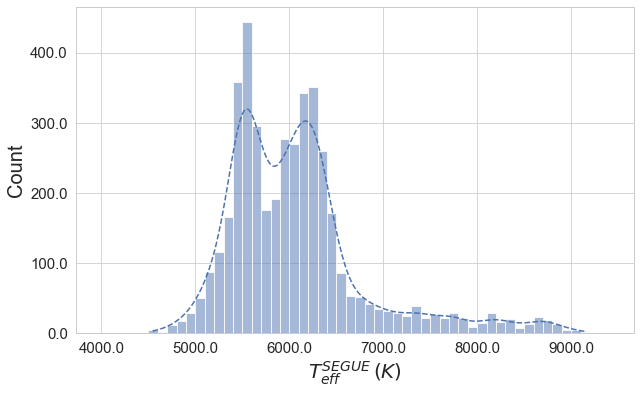

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
Teff = sns.histplot(y_train.TEFF_ADOP, bins = np.arange(4000,9500,100), kde=True, ax=ax, line_kws={'ls':'--','lw':1.5})
Teff.set_xlabel(r'$T_{eff}^{SEGUE}\,(K)$', fontsize=20)
Teff.set_ylabel('Count', fontsize=20)
Teff.set_xticklabels(Teff.get_xticks(), size = 15)
Teff.set_yticklabels(Teff.get_yticks(), size = 15)

[Text(0, 0, '0.0'),
 Text(0, 0, '100.0'),
 Text(0, 0, '200.0'),
 Text(0, 0, '300.0'),
 Text(0, 0, '400.0'),
 Text(0, 0, '500.0')]

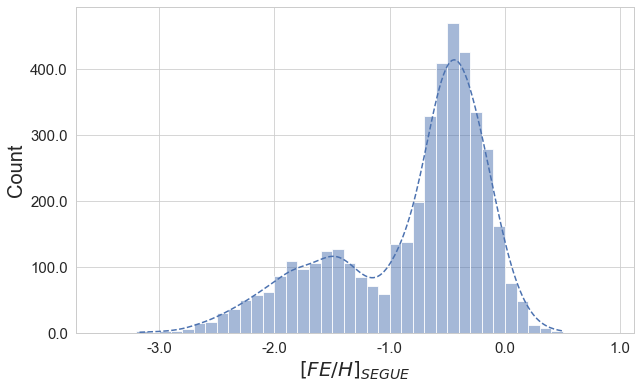

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
FeH = sns.histplot(y_train.FEH_ADOP, bins = np.arange(-3.5,1.0,0.1), kde=True, ax=ax, line_kws={'ls':'--','lw':1.5})
FeH.set_xlabel('$[FE/H]_{SEGUE}$',fontsize=20)
FeH.set_ylabel('Count', fontsize=20)
FeH.set_xticklabels(FeH.get_xticks(), size = 15)
FeH.set_yticklabels(FeH.get_yticks(), size = 15)

[Text(0, 0, '0.0'),
 Text(0, 0, '100.0'),
 Text(0, 0, '200.0'),
 Text(0, 0, '300.0'),
 Text(0, 0, '400.0'),
 Text(0, 0, '500.0'),
 Text(0, 0, '600.0'),
 Text(0, 0, '700.0')]

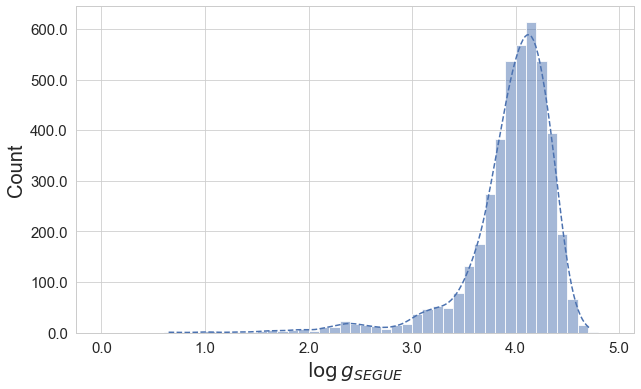

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
Logg = sns.histplot(y_train.LOGG_ADOP, bins = np.arange(0,5.0,0.1), kde=True, ax=ax, line_kws={'ls':'--','lw':1.5})
Logg.set_xlabel(r'$\log\,g_{SEGUE}$',fontsize=20)
Logg.set_ylabel('Count', fontsize=20)
Logg.set_xticklabels(Logg.get_xticks(), size = 15)
Logg.set_yticklabels(Logg.get_yticks(), size = 15)

In [12]:
from sklearn.pipeline import Pipeline, FeatureUnion

#Filters = AstroTools.Filters['JPLUS'] + AstroTools.Filters['GAIA'] + AstroTools.Filters['WISE']
'''
Colors_1 = ['uJAVAJ0378', 'J0378J0395', 'J0430J0861', 'J0660J0861', 'gSDSSJ0861', 'gSDSSzSDSS', 'BPRP', 'W1J']

Colors_2 = ['uJAVAJ0378J0410J0515', 'uJAVAJ0378rSDSSJ0660', 'uJAVAgSDSSJ0515J0660',
            'J0378J0430gSDSSJ0861', 'J0378J0430J0515J0861',
            'J0395J0430J0515J0861', 'J0395J0410J0660J0861',
            'J0410J0430gSDSSzSDSS']

Colors_1 = ['uJAVAJ0378', 'J0378J0395', 'J0395iSDSS', 'J0660J0861', 'J0430J0861', 'gSDSSiSDSS', 'BPRP',
            'W1J', 'JK']

Colors_2 = ['J0378J0395J0410J0861', 'J0378J0410gSDSSiSDSS', 'J0395J0410J0660J0861',
            'J0378J0430J0515J0861', 'J0410J0430gSDSSzSDSS', 'J0395J0410J0430J0515']
'''

JPLUS_Colors2 = ['J0410J0861', 'J0430J0660', 'J0430J0861', 'J0515J0861',  # Teff indicators narrow-band
                 'gSDSSiSDSS', 'gSDSSzSDSS',                              # Teff indicators broad-band
                 'uJAVAJ0378',                                            # [Fe/H] & Logg indicators
                 'uJAVAJ0430', 'uJAVAJ0410',                              # [Fe/H] indicators
                 'J0378J0395', 'J0378J0410', 'J0378J0430',
                 'J0395J0410', 'J0395J0430',
                 'uJAVAJ0395', 'J0660J0861']                              # Logg indicators

JPLUS_Colors4 = ['uJAVAJ0395J0410zSDSS',                                  # Teff indicator TESS Dataset
                 'J0378J0395J0410J0861', 'J0430iSDSSJ0861zSDSS',          # Teff indicators
                 'J0378J0410gSDSSiSDSS', 'J0378J0410J0515J0861',          # [Fe/H] indicators
                 'J0378J0430gSDSSiSDSS', 'J0378J0430gSDSSzSDSS',
                 'J0378J0430gSDSSJ0861',
                 'J0395J0410J0660J0861', 'J0395J0430J0660J0861',
                 'J0395J0430J0660zSDSS', 'J0395J0430rSDSSJ0861',
                 'J0395gSDSSJ0515J0861',
                 'uJAVAJ0378J0861zSDSS', 'J0378J0410J0430J0861']          # Logg indicators


best_jplus_colors2 = Pipeline([("filters", FeaturesSelection(Filters)),
                          ("colors_1", MakeColors(AstroTools.createColors2)),
                          ("features_select", FeaturesSelection(JPLUS_Colors2))])

best_jplus_colors4 = Pipeline([("colors_2", MakeColors(AstroTools.colorsComb)),
                          ("features_select", FeaturesSelection(JPLUS_Colors4))])

#union = FeatureUnion([("filters", FeaturesSelection(Filters)),
union = FeatureUnion([("Colors2", best_jplus_colors2),
                      ("Colors4", best_jplus_colors4)])


#union.fit_transform(X)

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from scipy.special import exp10
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor,GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.metrics import (mean_absolute_error, median_absolute_error, r2_score, max_error, 
                             mean_squared_error,explained_variance_score)

def Log10(X,column=0):

    X[:,column] = np.log10(X[:,column])
    
    return X

def Exp10(X,column=0):

    X[:,column] = exp10(X[:,column])
    
    return X

Tree = DecisionTreeRegressor()

reg_rf = RandomForestRegressor(n_estimators=350, max_features=15, bootstrap=True, random_state=42)
reg_gb = GradientBoostingRegressor(random_state=42)
reg_ab = AdaBoostRegressor(random_state=42)
reg_xgb = XGBRegressor(booster='gbtree', subsample=0.5, scale_pos_weight=10, num_parallel_tree=10,
                       max_delta_step=10, n_estimators = 100)
reg_et = ExtraTreesRegressor(random_state=42)

Model_1 = Pipeline([('features', union),
                    ('std_scaler', StandardScaler()),
                    ('rgr', RegressorChain(reg_rf))])

Model_RF = Pipeline([('features', union),
                     ('std_scaler', StandardScaler()),
                     ('rgr', MultiOutputRegressor(reg_rf))])

Model_GB = Pipeline([('features', union),
                     ('std_scaler', StandardScaler()),
                     ('rgr', MultiOutputRegressor(reg_gb))])

Model_AB = Pipeline([('features', union),
                     ('std_scaler', StandardScaler()),
                     ('rgr', MultiOutputRegressor(reg_ab))])

Model_XGB = Pipeline([('features', union),
                      ('std_scaler', StandardScaler()),
                      ('rgr', MultiOutputRegressor(reg_xgb))])

Model_ET = Pipeline([('features', union),
                     ('std_scaler', StandardScaler()),
                     ('rgr', MultiOutputRegressor(reg_et))])


Model_FINAL = TransformedTargetRegressor(Model_XGB, func=Log10,inverse_func=Exp10)

Model_FINAL.fit(X_train,y_train)

TransformedTargetRegressor(func=<function Log10 at 0x1a1cbb9680>,
                           inverse_func=<function Exp10 at 0x1b1d819a70>,
                           regressor=Pipeline(steps=[('features',
                                                      FeatureUnion(transformer_list=[('Colors2',
                                                                                      Pipeline(steps=[('filters',
                                                                                                       <__main__.FeaturesSelection object at 0x1a1c154690>),
                                                                                                      ('colors_1',
                                                                                                       <__main__.MakeColors object at 0x1a1c1548d0>),
                                                                                                      ('features_select',
                                                                                                       <__main__.Feat...
                                                                                                  importance_type='gain',
                                                                                                  interaction_constraints=None,
                                                                                                  learning_rate=None,
                                                                                                  max_delta_step=10,
                                                                                                  max_depth=None,
                                                                                                  min_child_weight=None,
                                                                                                  missing=nan,
                                                                                                  monotone_constraints=None,
                                                                                                  n_estimators=100,
                                                                                                  n_jobs=None,
                                                                                                  num_parallel_tree=10,
                                                                                                  random_state=None,
                                                                                                  reg_alpha=None,
                                                                                                  reg_lambda=None,
                                                                                                  scale_pos_weight=10,
                                                                                                  subsample=0.5,
                                                                                                  tree_method=None,
                                                                                                  validate_parameters=None,
                                                                                                  verbosity=None)))]))

In [14]:
y_predict_train = Model_FINAL.predict(X_train)

MAE_Teff_train = mean_absolute_error(y_predict_train[:,0],exp10(y_train.TEFF_ADOP))
MedE_Teff_train = median_absolute_error(y_predict_train[:,0],exp10(y_train.TEFF_ADOP))
MaxE_Teff_train = max_error(y_predict_train[:,0],exp10(y_train.TEFF_ADOP))
MSE_Teff_train = np.sqrt(mean_squared_error(y_predict_train[:,0],exp10(y_train.TEFF_ADOP)))
Var_Teff_train = explained_variance_score(y_predict_train[:,0],exp10(y_train.TEFF_ADOP))
R2_Teff_train = r2_score(y_predict_train[:,0],exp10(y_train.TEFF_ADOP))
print('MAE Teff = ',round(MAE_Teff_train,3))
print('Median Absolute Error Teff = ',round(MedE_Teff_train,3))
print('MSE Teff = ',round(MSE_Teff_train,3))
print('Max Error Teff = ',round(MaxE_Teff_train,3))
print('Variance Score Teff = ',round(Var_Teff_train,3))
print('R2 Teff = ',round(R2_Teff_train,3))

MAE_FeH_train = mean_absolute_error(y_predict_train[:,1],y_train.FEH_ADOP)
MedE_FeH_train = median_absolute_error(y_predict_train[:,1],y_train.FEH_ADOP)
MSE_FeH_train = np.sqrt(mean_squared_error(y_predict_train[:,1],y_train.FEH_ADOP))
MaxE_FeH_train = max_error(y_predict_train[:,1],y_train.FEH_ADOP)
Var_FeH_train = explained_variance_score(y_predict_train[:,1],y_train.FEH_ADOP)
R2_FeH_train = r2_score(y_predict_train[:,1],y_train.FEH_ADOP)
print('\nMAE FeH = ',round(MAE_FeH_train,3))
print('Median Absolute Error FeH = ',round(MedE_FeH_train,3))
print('MSE FeH = ',round(MSE_FeH_train,3))
print('Max Error FeH = ',round(MaxE_FeH_train,3))
print('Variance Score FeH = ',round(Var_FeH_train,3))
print('R2 FeH = ',round(R2_FeH_train,3))

MAE_Logg_train = mean_absolute_error(y_predict_train[:,2],y_train.LOGG_ADOP)
MedE_Logg_train = median_absolute_error(y_predict_train[:,2],y_train.LOGG_ADOP)
MSE_Logg_train = np.sqrt(mean_squared_error(y_predict_train[:,2],y_train.LOGG_ADOP))
MaxE_Logg_train = max_error(y_predict_train[:,2],y_train.LOGG_ADOP)
Var_Logg_train = explained_variance_score(y_predict_train[:,2],y_train.LOGG_ADOP)
R2_Logg_train = r2_score(y_predict_train[:,2],y_train.LOGG_ADOP)
print('\nMAE Logg = ',round(MAE_Logg_train,3))
print('Median Absolute Error Logg = ',round(MedE_Logg_train,3))
print('MSE Logg = ',round(MSE_Logg_train,3))
print('Max Error Logg = ',round(MaxE_Logg_train,3))
print('Variance Score Logg = ',round(Var_Logg_train,3))
print('R2 Logg = ',round(R2_Logg_train,3))

MAE Teff =  22.749
Median Absolute Error Teff =  18.325
MSE Teff =  29.559
Max Error Teff =  145.531
Variance Score Teff =  0.998
R2 Teff =  0.998

MAE FeH =  0.044
Median Absolute Error FeH =  0.036
MSE FeH =  0.057
Max Error FeH =  0.242
Variance Score FeH =  0.992
R2 FeH =  0.992

MAE Logg =  0.05
Median Absolute Error Logg =  0.039
MSE Logg =  0.067
Max Error Logg =  0.397
Variance Score Logg =  0.973
R2 Logg =  0.973


In [15]:
y_predict = Model_FINAL.predict(X_test)

MAE_Teff = mean_absolute_error(y_predict[:,0],y_test.TEFF_ADOP)
MedE_Teff = median_absolute_error(y_predict[:,0],y_test.TEFF_ADOP)
MaxE_Teff = max_error(y_predict[:,0],y_test.TEFF_ADOP)
MSE_Teff = np.sqrt(mean_squared_error(y_predict[:,0],y_test.TEFF_ADOP))
Var_Teff = explained_variance_score(y_predict[:,0],y_test.TEFF_ADOP)
R2_Teff = r2_score(y_predict[:,0],y_test.TEFF_ADOP)
print('MAE Teff = ',round(MAE_Teff,3))
print('Median Absolute Error Teff = ',round(MedE_Teff,3))
print('MSE Teff = ',round(MSE_Teff,3))
print('Max Error Teff = ',round(MaxE_Teff,3))
print('Variance Score Teff = ',round(Var_Teff,3))
print('R2 Teff = ',round(R2_Teff,3))

MAE_FeH = mean_absolute_error(y_predict[:,1],y_test.FEH_ADOP)
MedE_FeH = median_absolute_error(y_predict[:,1],y_test.FEH_ADOP)
MSE_FeH = np.sqrt(mean_squared_error(y_predict[:,1],y_test.FEH_ADOP))
MaxE_FeH = max_error(y_predict[:,1],y_test.FEH_ADOP)
Var_FeH = explained_variance_score(y_predict[:,1],y_test.FEH_ADOP)
R2_FeH = r2_score(y_predict[:,1],y_test.FEH_ADOP)
print('\nMAE FeH = ',round(MAE_FeH,3))
print('Median Absolute Error FeH = ',round(MedE_FeH,3))
print('MSE FeH = ',round(MSE_FeH,3))
print('Max Error FeH = ',round(MaxE_FeH,3))
print('Variance Score FeH = ',round(Var_FeH,3))
print('R2 FeH = ',round(R2_FeH,3))

MAE_Logg = mean_absolute_error(y_predict[:,2],y_test.LOGG_ADOP)
MedE_Logg = median_absolute_error(y_predict[:,2],y_test.LOGG_ADOP)
MSE_Logg = np.sqrt(mean_squared_error(y_predict[:,2],y_test.LOGG_ADOP))
MaxE_Logg = max_error(y_predict[:,2],y_test.LOGG_ADOP)
Var_Logg = explained_variance_score(y_predict[:,2],y_test.LOGG_ADOP)
R2_Logg = r2_score(y_predict[:,2],y_test.LOGG_ADOP)
print('\nMAE Logg = ',round(MAE_Logg,3))
print('Median Absolute Error Logg = ',round(MedE_Logg,3))
print('MSE Logg = ',round(MSE_Logg,3))
print('Max Error Logg = ',round(MaxE_Logg,3))
print('Variance Score Logg = ',round(Var_Logg,3))
print('R2 Logg = ',round(R2_Logg,3))

MAE Teff =  56.735
Median Absolute Error Teff =  41.723
MSE Teff =  90.965
Max Error Teff =  1369.001
Variance Score Teff =  0.985
R2 Teff =  0.985

MAE FeH =  0.156
Median Absolute Error FeH =  0.102
MSE FeH =  0.231
Max Error FeH =  1.917
Variance Score FeH =  0.859
R2 FeH =  0.859

MAE Logg =  0.162
Median Absolute Error Logg =  0.114
MSE Logg =  0.243
Max Error Logg =  1.82
Variance Score Logg =  0.456
R2 Logg =  0.452


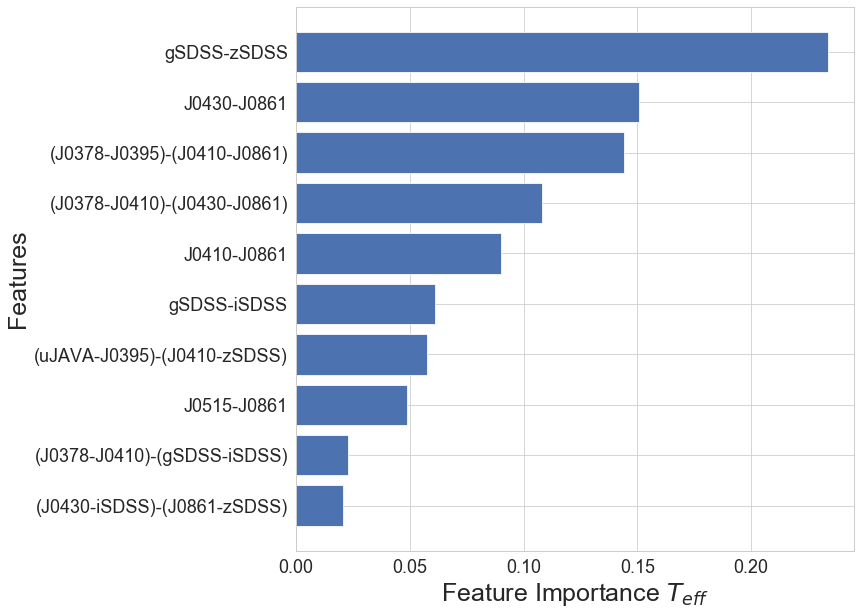

In [16]:
import matplotlib.pyplot as plt

# Feature Importance (Sorted Features)

#Columns = Filters + Colors_1 + Colors_2
Columns = JPLUS_Colors2 + JPLUS_Colors4

importance = Model_FINAL.regressor_[2].estimators_[0].feature_importances_

Features = {'Features':Columns, 'Importance':importance}
Features = pd.DataFrame(Features)
SortedFeatures = Features.sort_values(by=['Importance'], ascending=True)
#color_ticks_teff = ['J0430-J0861','(J0378-J0410)-(J0430-J0861)','gSDSS-zSDSS', 'J0515-J0861', 
#                    'J0410-J0861', 'gSDSS-iSDSS', '(J0378-J0395)-(J0410-J0861)',
#                    '(uJAVA-J0395)-(J0410-zSDSS)', '(J0378-J0410)-(gSDSS-iSDSS)',
#                    '(J0430-iSDSS)-(J0861-zSDSS)']
color_ticks_teff = ['gSDSS-zSDSS', 'J0430-J0861', '(J0378-J0395)-(J0410-J0861)', 
                    '(J0378-J0410)-(J0430-J0861)', 'J0410-J0861', 'gSDSS-iSDSS',
                    '(uJAVA-J0395)-(J0410-zSDSS)', 'J0515-J0861',
                    '(J0378-J0410)-(gSDSS-iSDSS)', '(J0430-iSDSS)-(J0861-zSDSS)']     # XGBoost Model
plt.figure(figsize=(10,10))
plt.barh(SortedFeatures.Features.tail(10),SortedFeatures.Importance.tail(10))
plt.xticks(fontsize=18)
#plt.yticks(fontsize=18)
plt.yticks(np.arange(9,-1,-1), color_ticks_teff, fontsize=18)
plt.xlabel('Feature Importance $T_{eff}$',fontsize=25)
plt.ylabel('Features',fontsize=25)
plt.show()

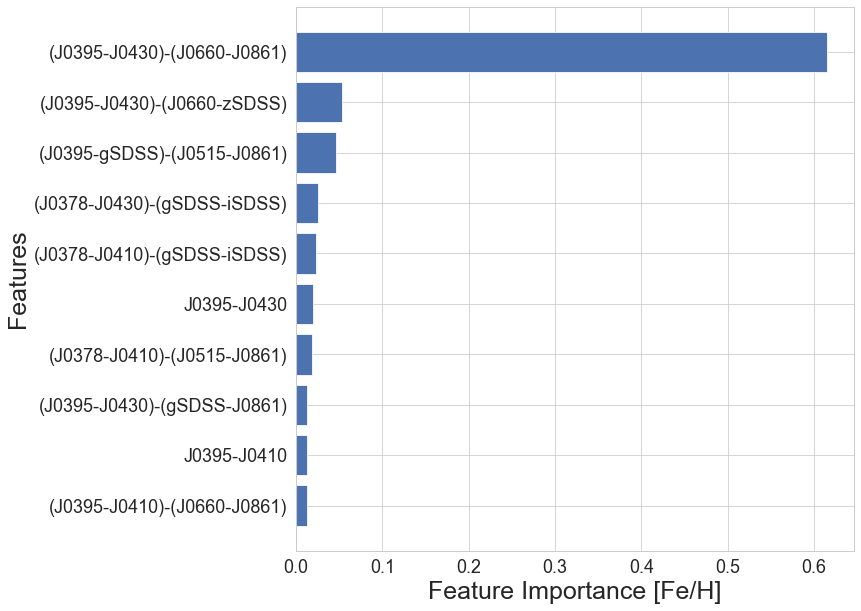

In [17]:
# Feature Importance (Sorted Features)

#Columns = Filters + Colors_1 + Colors_2

importance = Model_FINAL.regressor_[2].estimators_[1].feature_importances_

Features = {'Features':Columns, 'Importance':importance}
Features = pd.DataFrame(Features)
SortedFeatures = Features.sort_values(by=['Importance'], ascending=True)
#color_ticks_feh = ['(J0395-J0430)-(J0660-J0861)', '(J0395-J0430)-(J0660-zSDSS)', 
#                   '(J0395-gSDSS)-(J0515-J0861)', '(J0395-J0410)-(J0660-J0861)',
#                   '(J0395-J0430)-(rSDSS-J0861)', 'J0395-J0410', 'J0395-J0430',
#                   '(J0378-J0430)-(gSDSS-iSDSS)', '(J0378-J0410)-(gSDSS-iSDSS)',
#                   '(J0378-J0410)-(J0515-J0861)']
color_ticks_feh = ['(J0395-J0430)-(J0660-J0861)', '(J0395-J0430)-(J0660-zSDSS)', 
                   '(J0395-gSDSS)-(J0515-J0861)', '(J0378-J0430)-(gSDSS-iSDSS)', 
                   '(J0378-J0410)-(gSDSS-iSDSS)', 'J0395-J0430',
                   '(J0378-J0410)-(J0515-J0861)', '(J0395-J0430)-(gSDSS-J0861)',
                   'J0395-J0410', '(J0395-J0410)-(J0660-J0861)']      # XGBoost Model
plt.figure(figsize=(10,10))
plt.barh(SortedFeatures.Features.tail(10),SortedFeatures.Importance.tail(10))
plt.xticks(fontsize=18)
#plt.yticks(fontsize=18)
plt.yticks(np.arange(9,-1,-1), color_ticks_feh, fontsize=18)
plt.xlabel('Feature Importance [Fe/H]',fontsize=25)
plt.ylabel('Features',fontsize=25)
plt.show()

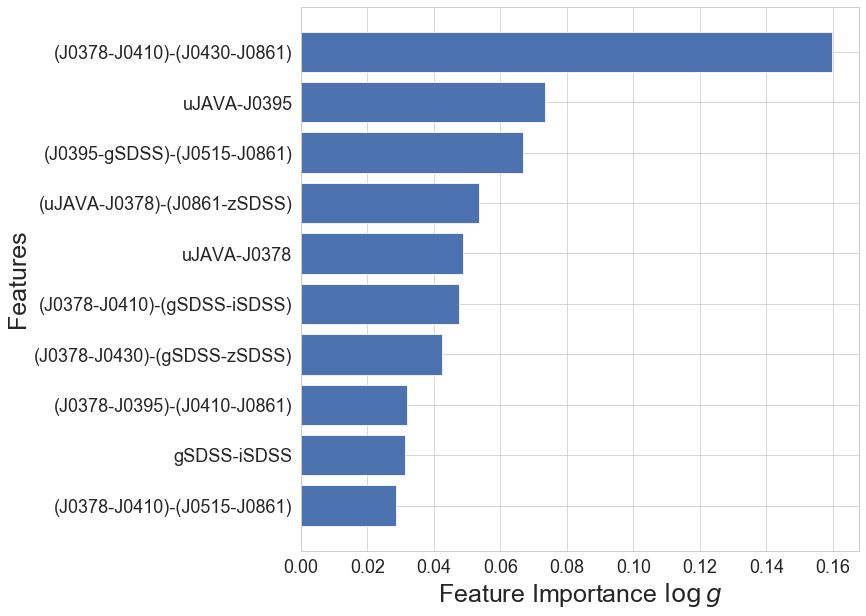

In [18]:
# Feature Importance (Sorted Features)

#Columns = Filters + Colors_1 + Colors_2
importance = Model_FINAL.regressor_[2].estimators_[2].feature_importances_

Features = {'Features':Columns, 'Importance':importance}
Features = pd.DataFrame(Features)
SortedFeatures = Features.sort_values(by=['Importance'], ascending=True)
#color_ticks_logg = ['uJAVA-J0378', '(J0378-J0410)-(J0430-J0861)', '(uJAVA-J0378)-(J0861-zSDSS)',
#                    'uJAVA-J0395', '(J0378-J0410)-(gSDSS-iSDSS)', '(J0378-J0430)-(gSDSS-zSDSS)',
#                    'uJAVA-J0430', '(J0378-J0430)-(gSDSS-J0861)', 'uJAVA-J0410',
#                    '(uJAVA-J0395)-(J0410-zSDSS)']
color_ticks_logg = ['(J0378-J0410)-(J0430-J0861)',  'uJAVA-J0395',
                    '(J0395-gSDSS)-(J0515-J0861)', '(uJAVA-J0378)-(J0861-zSDSS)',
                    'uJAVA-J0378', '(J0378-J0410)-(gSDSS-iSDSS)', '(J0378-J0430)-(gSDSS-zSDSS)', 
                    '(J0378-J0395)-(J0410-J0861)', 'gSDSS-iSDSS',
                    '(J0378-J0410)-(J0515-J0861)']   # XGBoost Model
plt.figure(figsize=(10,10))
plt.barh(SortedFeatures.Features.tail(10),SortedFeatures.Importance.tail(10))
plt.xticks(fontsize=18)
#plt.yticks(fontsize=18)
plt.yticks(np.arange(9,-1,-1), color_ticks_logg, fontsize=18)
plt.xlabel('Feature Importance $\log\,g$',fontsize=25)
plt.ylabel('Features',fontsize=25)
plt.show()

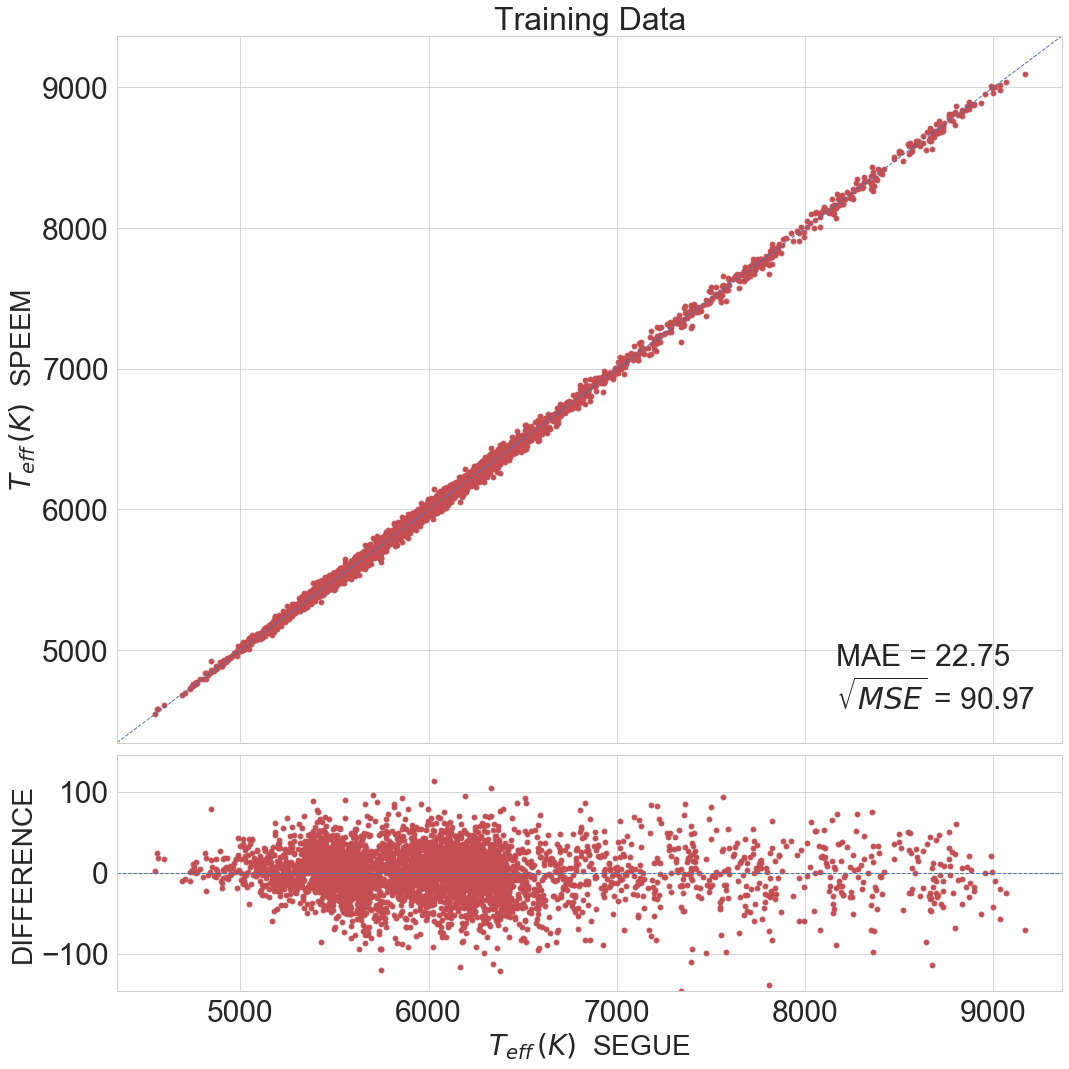

In [19]:
Differences_T_train = np.abs(y_predict_train[:,0] - y_train.TEFF_ADOP)
StandardDeviation_T_train = np.std(Differences_T_train)

error_T_train = str(round(MAE_Teff_train,2))
sigma_T_train = str(round(StandardDeviation_T_train,2))
label= 'MAE = ' + error_T_train + '\n$\sqrt{MSE}$ = ' + str(round(MSE_Teff,2))
Title = 'Training Data'
Xlabel = '$T_{eff}\,(K)$  SEGUE'
Ylabel = '$T_{eff}\,(K)$  SPEEM'

plot_params = {'X': exp10(y_train.TEFF_ADOP),
               'Y': y_predict_train[:,0],
               'minX': min(exp10(y_train.TEFF_ADOP))-200,
               'maxX': max(exp10(y_train.TEFF_ADOP))+200,
               'label': label,
               'title': Title,
               'xlabel': Xlabel,
               'ylabel': Ylabel,
               'frameon' : False,
               'markerscale' : 0,
               'loc' : 'lower right'}

AstroTools.AdjacentSubplots(**plot_params)

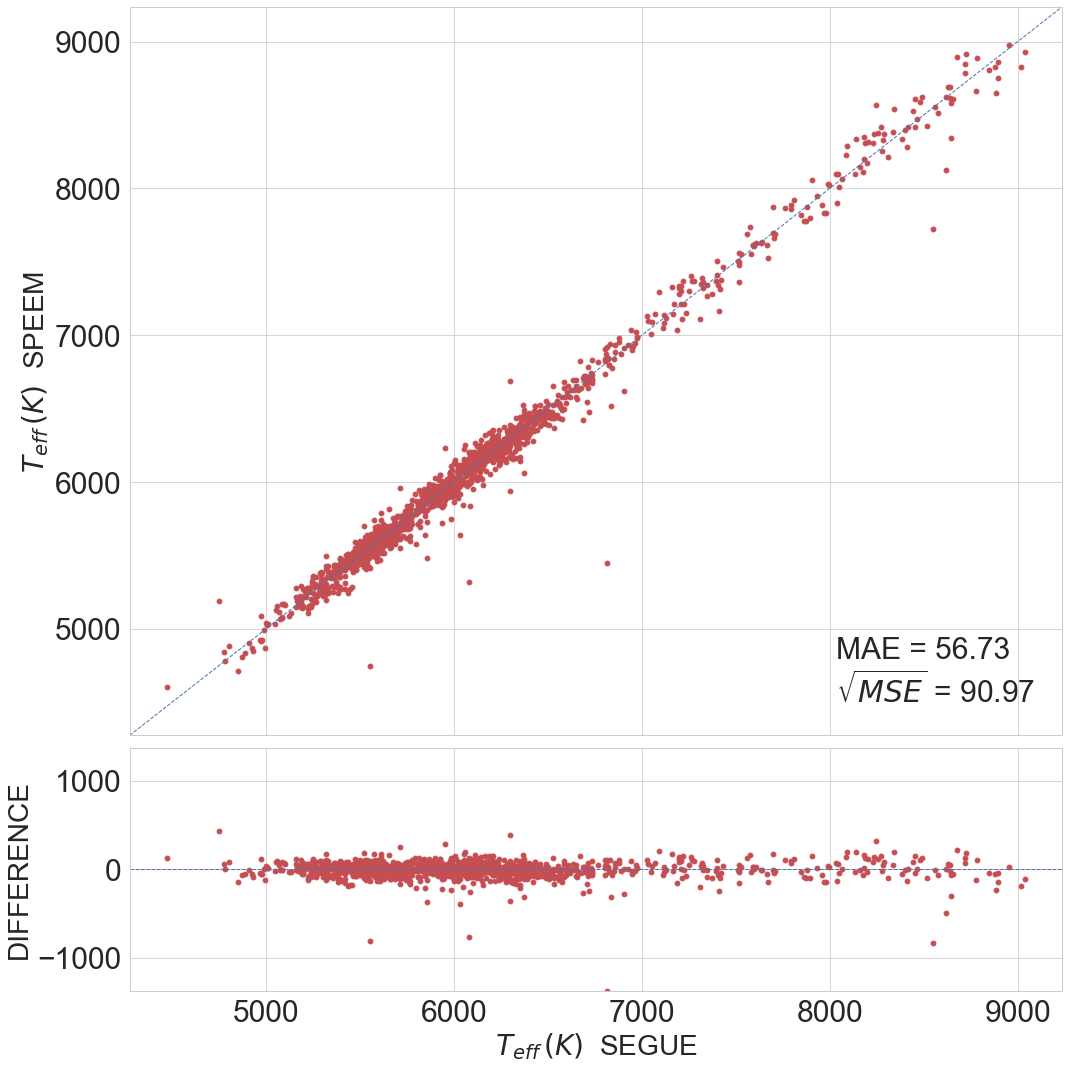

In [20]:
Differences_T = np.abs(y_predict[:,0] - y_test.TEFF_ADOP)
StandardDeviation_T = np.std(Differences_T)

error_T = str(round(MAE_Teff,2))
sigma_T = str(round(StandardDeviation_T,2))
label= 'MAE = ' + error_T + '\n$\sqrt{MSE}$ = ' + str(round(MSE_Teff,2))
Title = ''
Xlabel = '$T_{eff}\,(K)$  SEGUE'
Ylabel = '$T_{eff}\,(K)$  SPEEM'

plot_params = {'X': y_test.TEFF_ADOP,
               'Y': y_predict[:,0],
               'minX': min(y_test.TEFF_ADOP)-200,
               'maxX': max(y_test.TEFF_ADOP)+200,
               'label': label,
               'title': Title,
               'xlabel': Xlabel,
               'ylabel': Ylabel,
               'frameon' : False,
               'markerscale' : 0,
               'loc' : 'lower right'}

AstroTools.AdjacentSubplots(**plot_params)

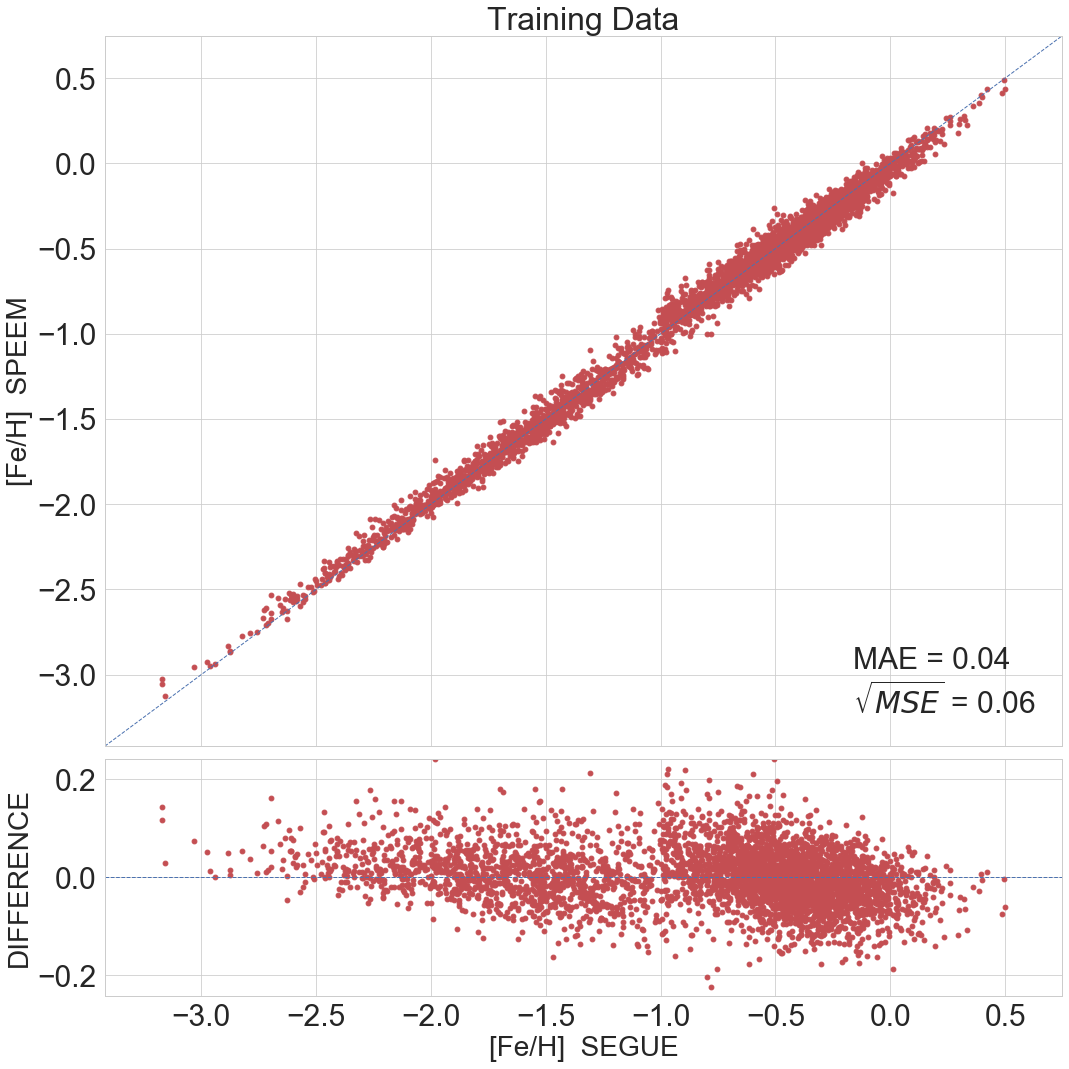

In [21]:
Differences_FEH_train = np.abs(y_predict_train[:,1] - y_train.FEH_ADOP)
StandardDeviation_FEH_train = np.std(Differences_FEH_train)
error_FEH_train = str(round(MAE_FeH_train,2))
sigma_FEH_train = str(round(StandardDeviation_FEH_train,2))
label= 'MAE = ' + error_FEH_train + '\n$\sqrt{MSE}$ = ' + str(round(MSE_FeH_train,2))
Title = 'Training Data'
Xlabel = '[Fe/H]  SEGUE'
Ylabel = '[Fe/H]  SPEEM'

plot_params = {'X': y_train.FEH_ADOP,
               'Y': y_predict_train[:,1],
               'minX': min(y_train.FEH_ADOP)-0.25,
               'maxX': max(y_train.FEH_ADOP)+0.25,
               'label': label,
               'title': Title,
               'xlabel': Xlabel,
               'ylabel': Ylabel,
               'markerscale' : 0,
               'frameon' : False}

AstroTools.AdjacentSubplots(**plot_params)

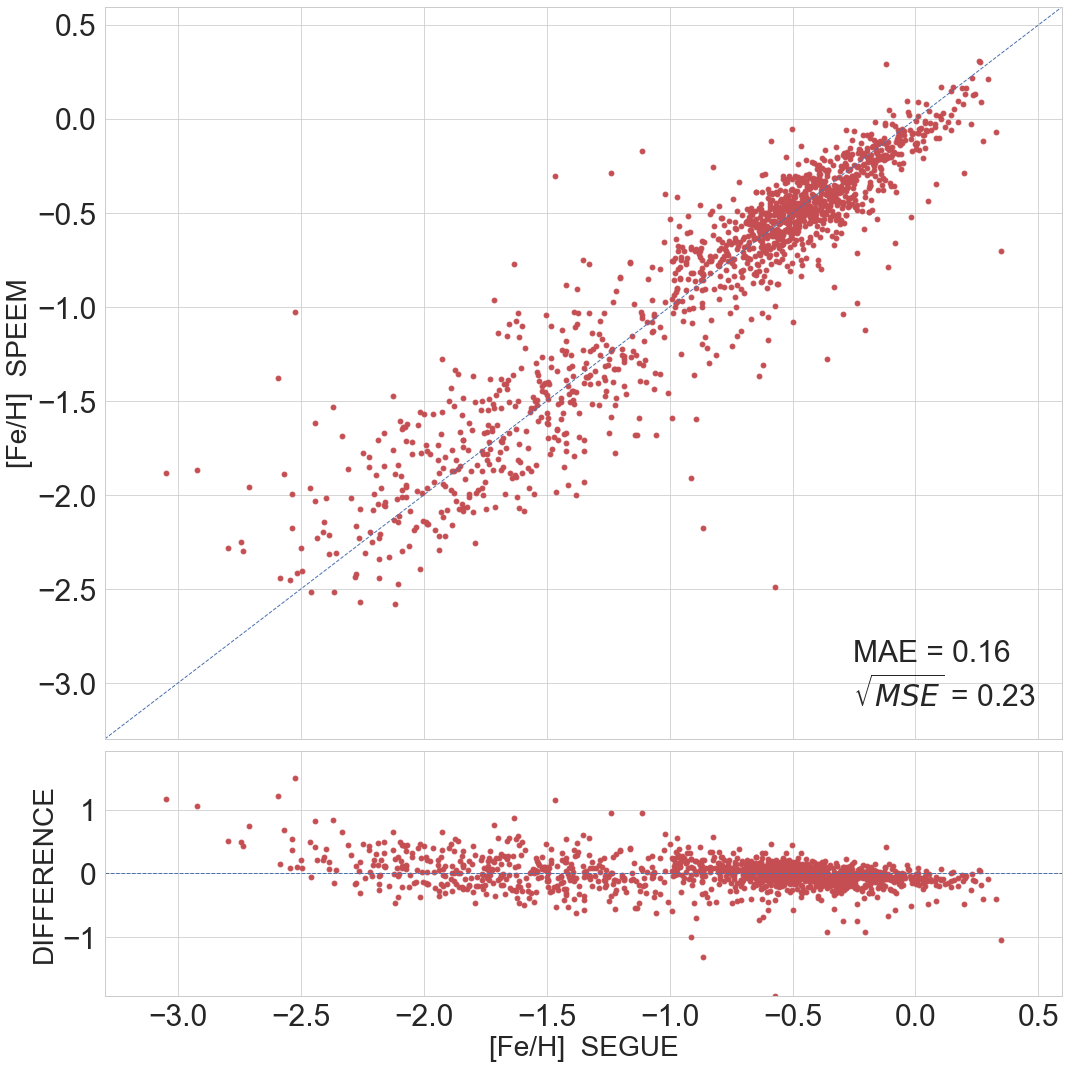

In [22]:
Differences_FEH = np.abs(y_predict[:,1] - y_test.FEH_ADOP)
StandardDeviation_FEH = np.std(Differences_FEH)
error = str(round(MAE_FeH,2))
sigma = str(round(StandardDeviation_FEH,2))
label= 'MAE = ' + error + '\n$\sqrt{MSE}$ = ' + str(round(MSE_FeH,2))
Title = ''
Xlabel = '[Fe/H]  SEGUE'
Ylabel = '[Fe/H]  SPEEM'

plot_params = {'X': y_test.FEH_ADOP,
               'Y': y_predict[:,1],
               'minX': min(y_test.FEH_ADOP)-0.25,
               'maxX': max(y_test.FEH_ADOP)+0.25,
               'label': label,
               'title': Title,
               'xlabel': Xlabel,
               'ylabel': Ylabel,
               'markerscale' : 0,
               'frameon' : False}

AstroTools.AdjacentSubplots(**plot_params)

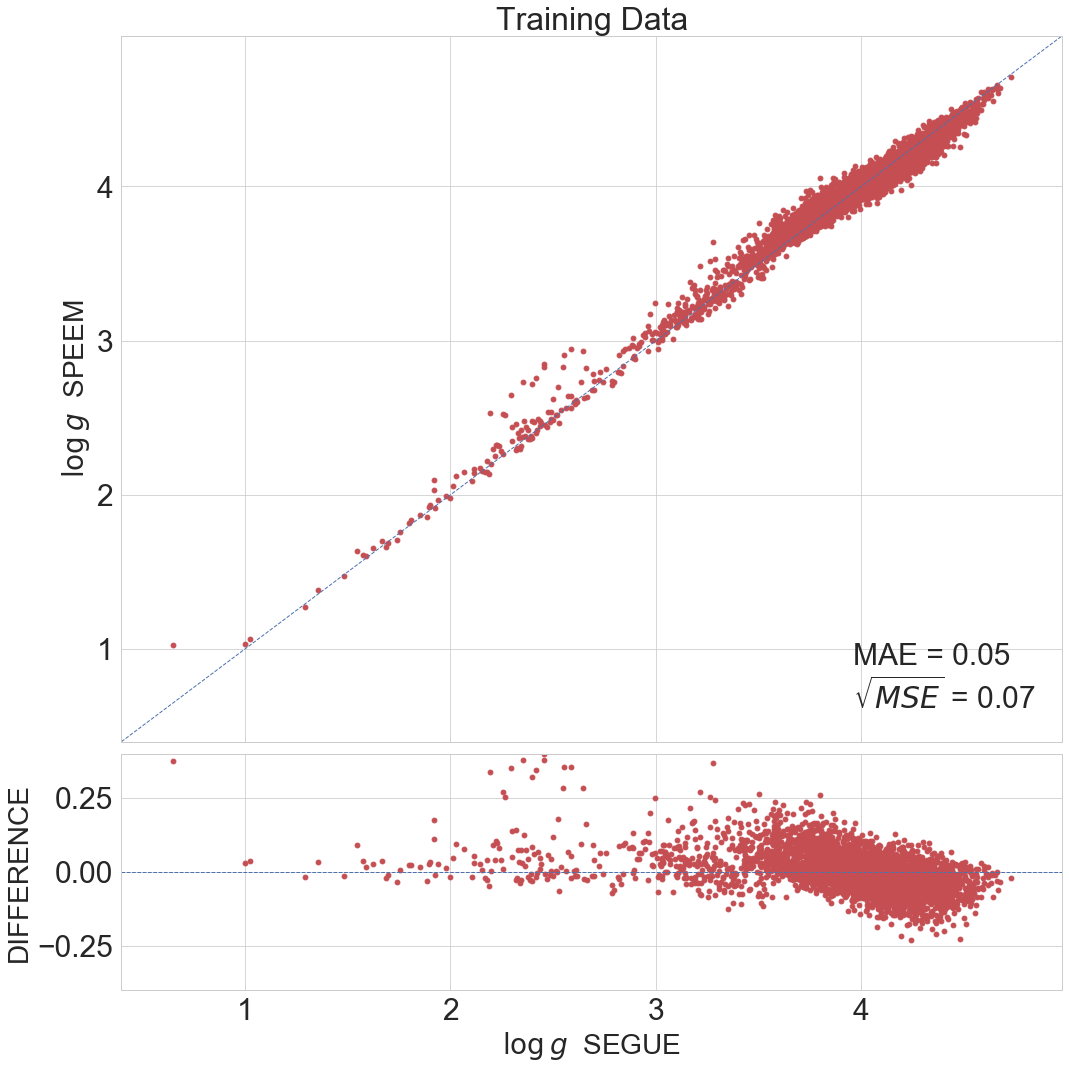

In [23]:
Differences_Logg_train = np.abs(y_predict_train[:,2] - y_train.LOGG_ADOP)
StandardDeviation_Logg_train = np.std(Differences_Logg_train)

error_Logg_train = str(round(MAE_Logg_train,2))
sigma_Logg_train = str(round(StandardDeviation_Logg_train,2))
label= 'MAE = ' + error_Logg_train + '\n$\sqrt{MSE}$ = ' + str(round(MSE_Logg_train,2))
Title = 'Training Data'
Xlabel = '$\log\,g$  SEGUE'
Ylabel = '$\log\,g$  SPEEM'

plot_params = {'X': y_train.LOGG_ADOP,
               'Y': y_predict_train[:,2],
               'minX': min(y_train.LOGG_ADOP)-0.25,
               'maxX': max(y_train.LOGG_ADOP)+0.25,
               'label': label,
               'title': Title,
               'xlabel': Xlabel,
               'ylabel': Ylabel,
               'markerscale' : 0,
               'frameon' : False}

AstroTools.AdjacentSubplots(**plot_params)

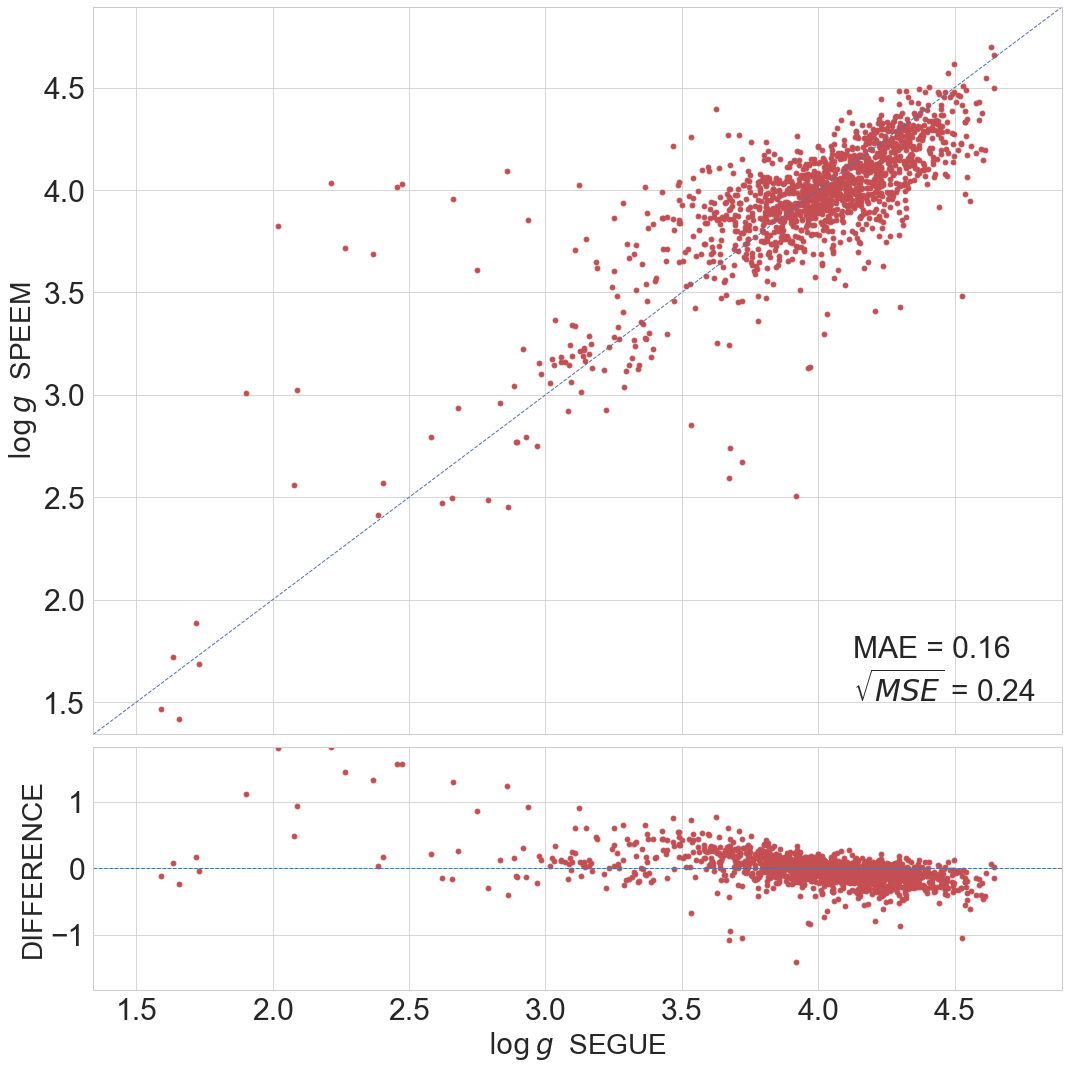

In [24]:
Differences_Logg = np.abs(y_predict[:,2] - y_test.LOGG_ADOP)
StandardDeviation_Logg = np.std(Differences_Logg)

error_Logg = str(round(MAE_Logg,2))
sigma_Logg = str(round(StandardDeviation_Logg,2))
label= 'MAE = ' + error_Logg + '\n$\sqrt{MSE}$ = ' + str(round(MSE_Logg,2))
Title = ''
Xlabel = '$\log\,g$  SEGUE'
Ylabel = '$\log\,g$  SPEEM'

plot_params = {'X': y_test.LOGG_ADOP,
               'Y': y_predict[:,2],
               'minX': min(y_test.LOGG_ADOP)-0.25,
               'maxX': max(y_test.LOGG_ADOP)+0.25,
               'label': label,
               'title': Title,
               'xlabel': Xlabel,
               'ylabel': Ylabel,
               'markerscale' : 0,
               'frameon' : False}

AstroTools.AdjacentSubplots(**plot_params)

In [25]:
Test_SSPP = y_test.assign(teff_predict = y_predict[:,0])
Test_SSPP = Test_SSPP.assign(feh_predict = y_predict[:,1])
Test_SSPP = Test_SSPP.assign(logg_predict = y_predict[:,2])

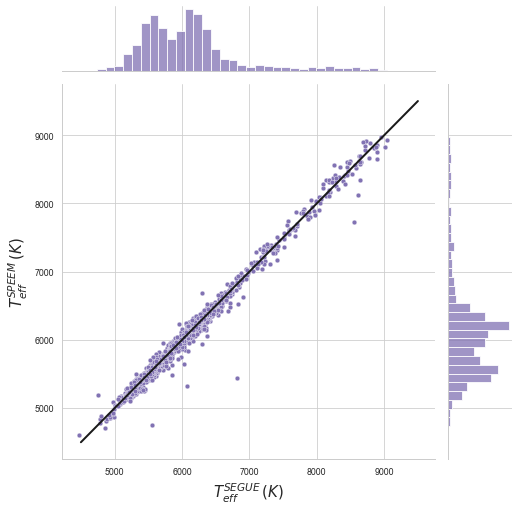

In [26]:
import seaborn as sns

#sns.set(style="darkgrid")
sns.set_context("paper")

g = sns.jointplot(data=Test_SSPP, x="TEFF_ADOP", y="teff_predict", 
                  kind="scatter",color="m",height=7)

g.ax_joint.plot([4500,9500], [4500,9500], 'k-', linewidth = 2)
g.ax_joint.set_xlabel(r'$T_{eff}^{SEGUE}\,(K)$',fontsize=15)
g.ax_joint.set_ylabel(r'$T_{eff}^{SPEEM}\,(K)$',fontsize=15)
g.ax_joint.grid('on')

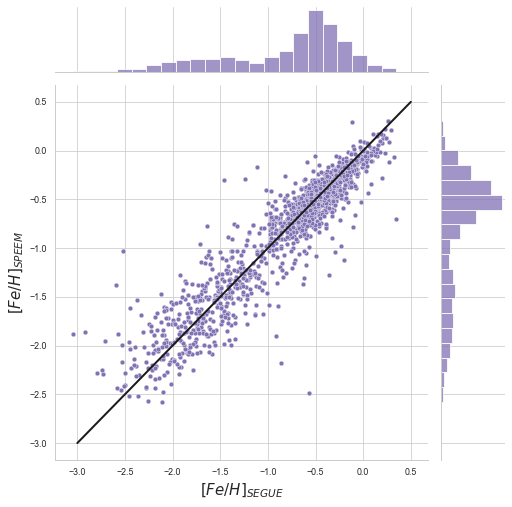

In [27]:
#sns.set(style="darkgrid")
sns.set_context("paper")

g = sns.jointplot(data=Test_SSPP, x ="FEH_ADOP", y = "feh_predict",
                  kind="scatter",color="m",height=7)

g.ax_joint.plot([-3.0,0.5], [-3.0,0.5], 'k-', linewidth = 2)
g.ax_joint.set_xlabel(r'$[Fe/H]_{SEGUE}$',fontsize=15)
g.ax_joint.set_ylabel(r'$[Fe/H]_{SPEEM}$',fontsize=15)
g.ax_joint.grid('on')

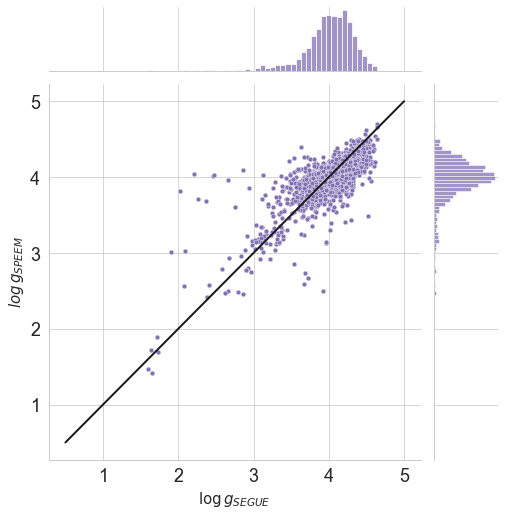

In [28]:
#sns.set(style="darkgrid")
sns.set_context("paper")

#g = sns.jointplot("LOGG_ADOP", "logg_predict", data=Test_clean_SSPP,
#                  kind="reg",lowess=True,truncate=False,color="m",height=7,
#                  joint_kws={'line_kws':{'color':'black'}})

g = sns.jointplot(data=Test_SSPP, x="LOGG_ADOP", y="logg_predict",
                  kind="scatter",color="m",height=7)

g.ax_joint.plot([0.5,5.0], [0.5,5.0], 'k-', linewidth = 2)
g.ax_joint.set_xlabel(r'$\log\,g_{SEGUE}$',fontsize=15)
g.ax_joint.set_ylabel(r'$log\,g_{SPEEM}$',fontsize=15)
g.ax_joint.tick_params(axis="both", labelsize=18)
g.ax_joint.grid('on')

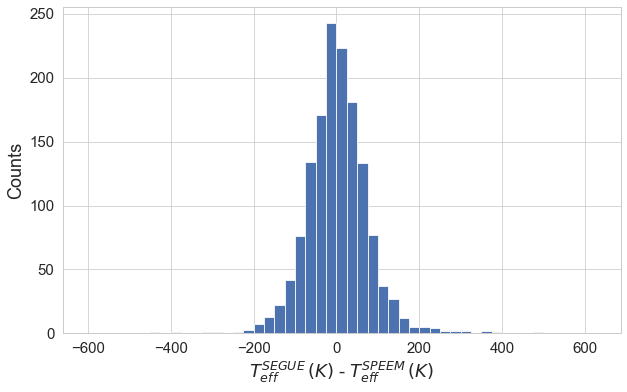

In [29]:
import matplotlib.pyplot as plt

#Test_SSPP['Diff_TEFF'] = np.abs(Test_SSPP.TEFF_ADOP - Test_SSPP.teff_predict)
Test_SSPP = Test_SSPP.assign(diff_teff = (Test_SSPP.TEFF_ADOP - Test_SSPP.teff_predict))
Test_SSPP.diff_teff.hist(figsize = (10,6), bins = np.arange(-600,650,25))#np.arange(0,MaxE_Teff,50))
#plt.title('Histogram of TEFF Errors for Test Sample ', fontsize=25)
plt.xlabel(r'$T_{eff}^{SEGUE}\,(K)$ - $T_{eff}^{SPEEM}\,(K)}$', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.tick_params(axis="both", labelsize=15)

(-500, 500)

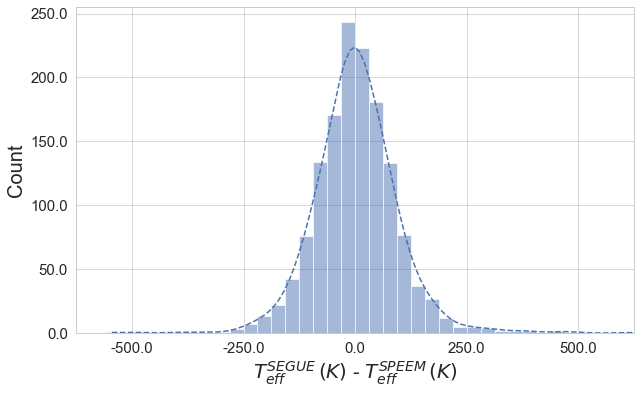

In [30]:
fig, ax = plt.subplots(figsize=(10,6))
Teff_err = sns.histplot((Test_SSPP.diff_teff),
                        bins = np.arange(-600,650,25), kde=True, ax=ax, line_kws={'ls':'--','lw':1.5})
Teff_err.set_xlabel(r'$T_{eff}^{SEGUE}\,(K)$ - $T_{eff}^{SPEEM}\,(K)}$', fontsize=20)
Teff_err.set_ylabel('Count', fontsize=20)
Teff_err.set_xticklabels(Teff_err.get_xticks(), size = 15)
Teff_err.set_yticklabels(Teff_err.get_yticks(), size = 15)
#Teff_err.set_xlim((-600,600))
plt.xlim(-500,500)

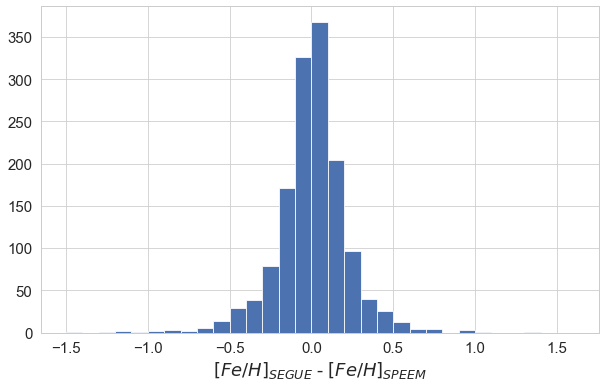

In [31]:
Test_SSPP = Test_SSPP.assign(diff_feh = (Test_SSPP.FEH_ADOP - Test_SSPP.feh_predict))
Test_SSPP.diff_feh.hist(figsize = (10,6), bins = np.arange(-1.5,1.7,0.1))#np.arange(0,MaxE_FeH,0.2))
#plt.title('Histogram of [FE/H] Errors for Test Sample ', fontsize=18)
plt.xlabel('$[Fe/H]_{SEGUE}$ - $[Fe/H]_{SPEEM}$', fontsize=18)
plt.tick_params(axis="both", labelsize=15)

[Text(0, 0, '0.0'),
 Text(0, 0, '50.0'),
 Text(0, 0, '100.0'),
 Text(0, 0, '150.0'),
 Text(0, 0, '200.0'),
 Text(0, 0, '250.0'),
 Text(0, 0, '300.0'),
 Text(0, 0, '350.0'),
 Text(0, 0, '400.0')]

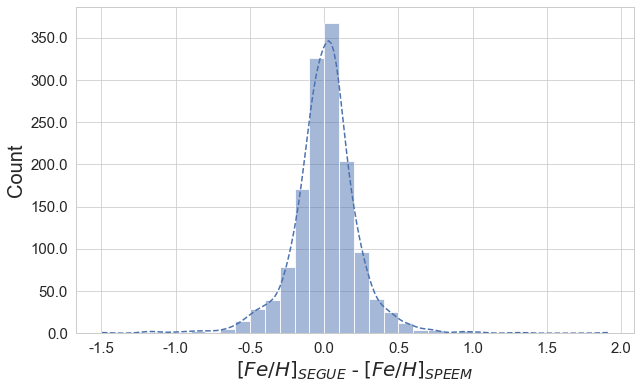

In [32]:
fig, ax = plt.subplots(figsize=(10,6))
FeH_err = sns.histplot((Test_SSPP.diff_feh),
                        bins = np.arange(-1.5,1.7,0.1), kde=True, ax=ax, line_kws={'ls':'--','lw':1.5})
FeH_err.set_xlabel(r'$[Fe/H]_{SEGUE}$ - $[Fe/H]_{SPEEM}$', fontsize=20)
FeH_err.set_ylabel('Count', fontsize=20)
FeH_err.set_xticklabels(FeH_err.get_xticks(), size = 15)
FeH_err.set_yticklabels(FeH_err.get_yticks(), size = 15)
#FeH_err.set_xlim((-1.5,1.5))

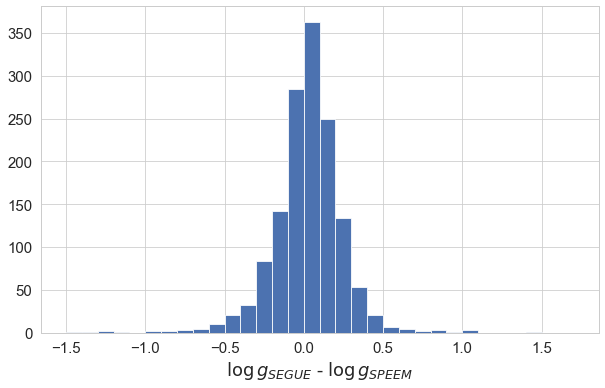

In [33]:
Test_SSPP = Test_SSPP.assign(diff_logg = (Test_SSPP.LOGG_ADOP - Test_SSPP.logg_predict))
Test_SSPP.diff_logg.hist(figsize = (10,6), bins = np.arange(-1.5,1.75,0.1))##np.arange(0,MaxE_Logg,0.25))
#plt.title('Histogram of LOGG Errors for Test Sample ', fontsize=25)
plt.xlabel('$\log\,g_{SEGUE}$ - $\log\,g_{SPEEM}$', fontsize=18)
plt.tick_params(axis="both", labelsize=15)

[Text(0, 0, '0.0'),
 Text(0, 0, '50.0'),
 Text(0, 0, '100.0'),
 Text(0, 0, '150.0'),
 Text(0, 0, '200.0'),
 Text(0, 0, '250.0'),
 Text(0, 0, '300.0'),
 Text(0, 0, '350.0'),
 Text(0, 0, '400.0')]

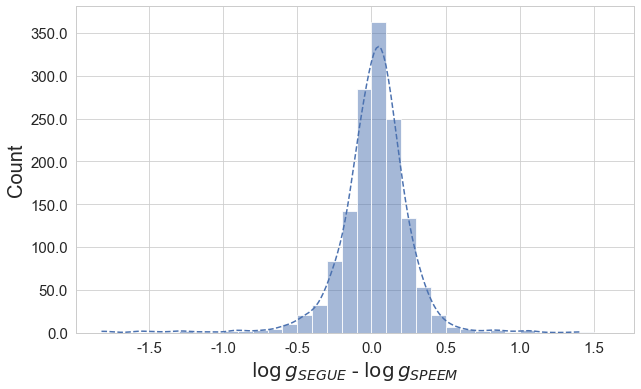

In [34]:
fig, ax = plt.subplots(figsize=(10,6))
logg_err = sns.histplot((Test_SSPP.diff_logg),
                        bins = np.arange(-1.5,1.7,0.1), kde=True, ax=ax, line_kws={'ls':'--','lw':1.5})
logg_err.set_xlabel(r'$\log\,g_{SEGUE}$ - $\log\,g_{SPEEM}$', fontsize=20)
logg_err.set_ylabel('Count', fontsize=20)
logg_err.set_xticklabels(logg_err.get_xticks(), size = 15)
logg_err.set_yticklabels(logg_err.get_yticks(), size = 15)

In [35]:
AstroTools.ChangeFolder(path , '/Users/Andres/Documents/PhD/JPLUS_Code/Datasets/')
df = AstroTools.Read_Dataset('idr202005/VMP_Candidates_DR2_Photometry.csv')

Working_df = (df.pipe(correctMags)            # MW Correction
              .pipe(add_id_columns, df, ['NAME'] + AstroTools.Reference['Full'])       # Add TILE_ID, NUMBER, RA, DEC
              .pipe(order_columns, ['NAME'] + AstroTools.Reference['Full'])            # Reorder columns
              .pipe(add_gaia_filters, df)     # Add GAIA Filters
              .pipe(add_wise_filters, df)     # Add WISE and 2MASS Filters
              .pipe(add_stellar_params, df, ['Teff_GAIA', 'Teff_RF', 'Logg_RF', 'FeH_RF'])   # Add teff, feh, logg to Dataframe
             )

Working_df.head(5)

Last path:  /Users/Andres/Documents/PhD/JPLUS_Code/Scripts_and_Notebooks
New path is: /Users/Andres/Documents/PhD/JPLUS_Code/Datasets/


,NAME,TILE_ID,NUMBER,RA,DEC,FWHM_WORLD,uJAVA,J0378,J0395,J0410,...,W2,W3,W4,J,H,K,Teff_GAIA,Teff_RF,Logg_RF,FeH_RF
0,VMP01,72863,2745,23.657707,6.903066,0.000243,18.245,17.691,17.529,17.198,...,13.957,12.135,9.072,14.679,14.113,14.073,4936.00000,5138.265614,2.071433,-2.526315
1,VMP02,66430,46822,279.338279,42.069825,0.000341,17.895,17.376,17.268,17.023,...,14.105,12.961,9.506,14.682,14.199,14.136,5038.22000,5316.079105,2.318208,-2.464832
2,VMP03,72875,16592,23.852263,7.669372,0.000292,17.862,17.477,17.410,17.078,...,14.111,12.126,8.337,14.815,14.202,14.133,4860.00000,5309.313608,2.343242,-2.424612
3,VMP04,73136,5464,343.681604,9.842374,0.000274,17.795,17.480,17.287,17.092,...,14.407,12.621,9.117,15.028,14.483,14.611,5152.25000,5441.237238,3.113244,-2.620461
4,VMP05,73259,21448,342.166186,12.194307,0.000327,17.556,17.159,16.996,16.807,...,13.831,12.265,8.418,14.472,13.903,13.870,4968.50977,5221.109006,2.227581,-2.502137


In [36]:
Preds = Model_FINAL.predict(Working_df)
teff_new, feh_new, logg_new = Preds[:,0], Preds[:,1], Preds[:,2]

Working_df['feh_new'] = feh_new
Working_df['teff_new'] = teff_new
Working_df['logg_new'] = logg_new

Working_df['teff_photo'] = (0.08*((Working_df.uJAVA - Working_df.J0395) - (Working_df.J0410 - Working_df.zSDSS)) + 3.81)
Working_df['teff_photo'] = 10**(Working_df.teff_photo)

In [37]:
Candidates = Working_df[['NAME','TILE_ID','NUMBER','RA','DEC','gSDSS',
                         'Teff_RF','FeH_RF','Logg_RF', 'teff_photo',
                         'Teff_GAIA','teff_new','feh_new','logg_new']]

Lista = Candidates[['NAME','TILE_ID','NUMBER','RA','DEC','gSDSS','Teff_RF','FeH_RF','Logg_RF','teff_photo',
                    'teff_new','feh_new','logg_new','Teff_GAIA']].reset_index().drop(columns='index')

Lista

,NAME,TILE_ID,NUMBER,RA,DEC,gSDSS,Teff_RF,FeH_RF,Logg_RF,teff_photo,teff_new,feh_new,logg_new,Teff_GAIA
0,VMP01,72863,2745,23.657707,6.903066,16.697,5138.265614,-2.526315,2.071433,5635.857453,5033.040039,-3.040427,1.679989,4936.00000
1,VMP02,66430,46822,279.338279,42.069825,16.596,5316.079105,-2.464832,2.318208,5745.925622,5197.740234,-2.686036,2.271399,5038.22000
2,VMP03,72875,16592,23.852263,7.669372,16.636,5309.313608,-2.424612,2.343242,5557.506765,5218.990723,-2.566935,2.646327,4860.00000
3,VMP04,73136,5464,343.681604,9.842374,16.710,5441.237238,-2.620461,3.113244,5801.228876,5419.014648,-2.518730,2.782737,5152.25000
4,VMP05,73259,21448,342.166186,12.194307,16.324,5221.109006,-2.502137,2.227581,5565.702647,5216.905273,-2.625828,2.422752,4968.50977
5,VMP06,75293,17425,224.324545,54.202942,16.582,5216.788197,-2.510312,2.124596,5686.957727,5156.676758,-2.765576,1.951675,5012.04000
6,VMP09,73039,16081,332.812106,10.581480,16.410,5042.386066,-2.493682,1.971178,5576.991724,5077.418457,-2.721834,1.951480,4911.04980
7,VMP10,75091,15989,38.842935,43.464397,14.756,5310.392065,-2.371062,2.529530,5761.824156,5326.472656,-2.577951,2.539170,5058.06006
8,VMP11,71582,10685,3.276179,2.512994,14.931,5290.596930,-2.299849,2.214529,5596.544998,5166.401855,-2.697026,2.191016,5104.83000
9,VMP12,66416,5807,276.841772,41.064315,16.492,5180.495032,-2.478804,2.204965,5649.369748,5204.059082,-2.666419,1.835807,4994.49023


In [38]:
Lista = Lista.drop(5).copy()
Lista

,NAME,TILE_ID,NUMBER,RA,DEC,gSDSS,Teff_RF,FeH_RF,Logg_RF,teff_photo,teff_new,feh_new,logg_new,Teff_GAIA
0,VMP01,72863,2745,23.657707,6.903066,16.697,5138.265614,-2.526315,2.071433,5635.857453,5033.040039,-3.040427,1.679989,4936.00000
1,VMP02,66430,46822,279.338279,42.069825,16.596,5316.079105,-2.464832,2.318208,5745.925622,5197.740234,-2.686036,2.271399,5038.22000
2,VMP03,72875,16592,23.852263,7.669372,16.636,5309.313608,-2.424612,2.343242,5557.506765,5218.990723,-2.566935,2.646327,4860.00000
3,VMP04,73136,5464,343.681604,9.842374,16.710,5441.237238,-2.620461,3.113244,5801.228876,5419.014648,-2.518730,2.782737,5152.25000
4,VMP05,73259,21448,342.166186,12.194307,16.324,5221.109006,-2.502137,2.227581,5565.702647,5216.905273,-2.625828,2.422752,4968.50977
6,VMP09,73039,16081,332.812106,10.581480,16.410,5042.386066,-2.493682,1.971178,5576.991724,5077.418457,-2.721834,1.951480,4911.04980
7,VMP10,75091,15989,38.842935,43.464397,14.756,5310.392065,-2.371062,2.529530,5761.824156,5326.472656,-2.577951,2.539170,5058.06006
8,VMP11,71582,10685,3.276179,2.512994,14.931,5290.596930,-2.299849,2.214529,5596.544998,5166.401855,-2.697026,2.191016,5104.83000
9,VMP12,66416,5807,276.841772,41.064315,16.492,5180.495032,-2.478804,2.204965,5649.369748,5204.059082,-2.666419,1.835807,4994.49023
10,VMP13,66723,1757,239.573991,42.377617,15.765,5286.249542,-2.675106,2.117019,5578.019138,5118.212891,-2.949422,2.362777,5058.06000


In [39]:
''' SNAME       FEH      EFEH   TEFF  ETEFF      LOGG     ELOGG
    VMP01    -3.130     0.141   4803    154     0.389     0.295
    VMP02    -2.644     0.235   5016     96     1.073     1.138
    VMP03    -3.179     0.180   4857    111     1.088     0.012
    VMP04    -2.800     0.114   5498     72     2.151     0.435
    VMP05    -3.087     0.289   5186    117     2.662     0.907
    VMP09    -2.227     0.121   5194     68     2.439     0.524
    VMP10    -3.255     0.194   5153     89     1.684     0.702
    VMP11    -2.634     0.117   5315    174     3.007     0.549
    VMP12    -2.937     0.224   5113    112     0.469     0.052
    VMP13    -3.104     0.099   4805     91     1.103     0.624 '''


teff_spec = [4803,5016,4857,5498,5186,5194,5153,5315,5113,4805]
feh_spec = [-3.130,-2.644,-3.179,-2.800,-3.087,-2.227,-3.255,-2.634,-2.937,-3.104]
logg_spec = [0.389,1.073,1.088,2.151,2.662,2.439,1.684,3.007,0.469,1.103]

Lista['teff_spec'] = teff_spec
Lista['feh_spec'] = feh_spec
Lista['logg_spec'] = logg_spec

Lista

,NAME,TILE_ID,NUMBER,RA,DEC,gSDSS,Teff_RF,FeH_RF,Logg_RF,teff_photo,teff_new,feh_new,logg_new,Teff_GAIA,teff_spec,feh_spec,logg_spec
0,VMP01,72863,2745,23.657707,6.903066,16.697,5138.265614,-2.526315,2.071433,5635.857453,5033.040039,-3.040427,1.679989,4936.00000,4803,-3.130,0.389
1,VMP02,66430,46822,279.338279,42.069825,16.596,5316.079105,-2.464832,2.318208,5745.925622,5197.740234,-2.686036,2.271399,5038.22000,5016,-2.644,1.073
2,VMP03,72875,16592,23.852263,7.669372,16.636,5309.313608,-2.424612,2.343242,5557.506765,5218.990723,-2.566935,2.646327,4860.00000,4857,-3.179,1.088
3,VMP04,73136,5464,343.681604,9.842374,16.710,5441.237238,-2.620461,3.113244,5801.228876,5419.014648,-2.518730,2.782737,5152.25000,5498,-2.800,2.151
4,VMP05,73259,21448,342.166186,12.194307,16.324,5221.109006,-2.502137,2.227581,5565.702647,5216.905273,-2.625828,2.422752,4968.50977,5186,-3.087,2.662
6,VMP09,73039,16081,332.812106,10.581480,16.410,5042.386066,-2.493682,1.971178,5576.991724,5077.418457,-2.721834,1.951480,4911.04980,5194,-2.227,2.439
7,VMP10,75091,15989,38.842935,43.464397,14.756,5310.392065,-2.371062,2.529530,5761.824156,5326.472656,-2.577951,2.539170,5058.06006,5153,-3.255,1.684
8,VMP11,71582,10685,3.276179,2.512994,14.931,5290.596930,-2.299849,2.214529,5596.544998,5166.401855,-2.697026,2.191016,5104.83000,5315,-2.634,3.007
9,VMP12,66416,5807,276.841772,41.064315,16.492,5180.495032,-2.478804,2.204965,5649.369748,5204.059082,-2.666419,1.835807,4994.49023,5113,-2.937,0.469
10,VMP13,66723,1757,239.573991,42.377617,15.765,5286.249542,-2.675106,2.117019,5578.019138,5118.212891,-2.949422,2.362777,5058.06000,4805,-3.104,1.103


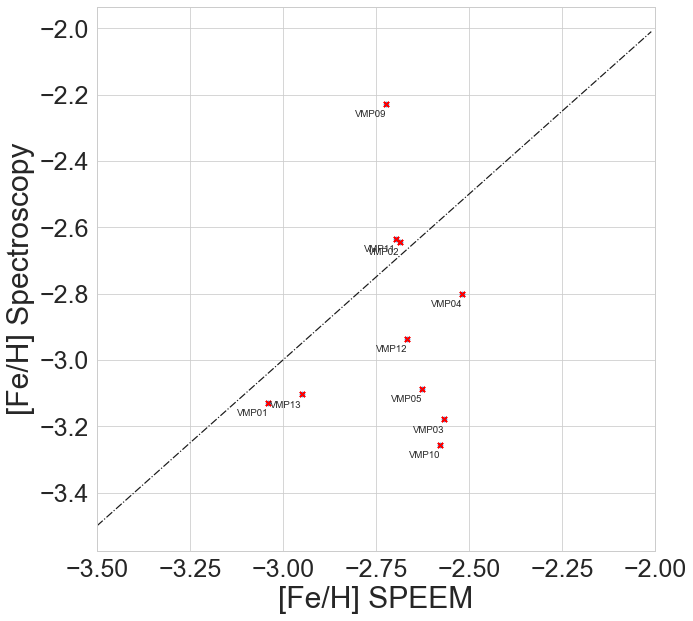

In [40]:
import matplotlib.pyplot as plt

# FeH Photometry vs Spectroscopy
x = Lista['feh_new'].values
y = Lista['feh_spec'].values

x2 = np.arange(-3.5,-2.00,0.01)
#y2 = (1.5/0.6)*x2+3.5


types = Lista.reset_index()['NAME'].values

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x, y)
plt.plot(x2,x2,'-.k')

ax.tick_params('both',labelsize=25)
ax.set_xlabel('[Fe/H] SPEEM', fontsize=30)
ax.set_ylabel('[Fe/H] Spectroscopy', fontsize=30)

ax.set_xlim(-3.5,-2.0)
ax.grid(True)

for i, txt in enumerate(types):
    ax.annotate(txt, (x[i], y[i]), xytext=(0,-15), textcoords='offset points',ha='right',va='bottom')
    plt.scatter(x, y, marker='x', color='red')

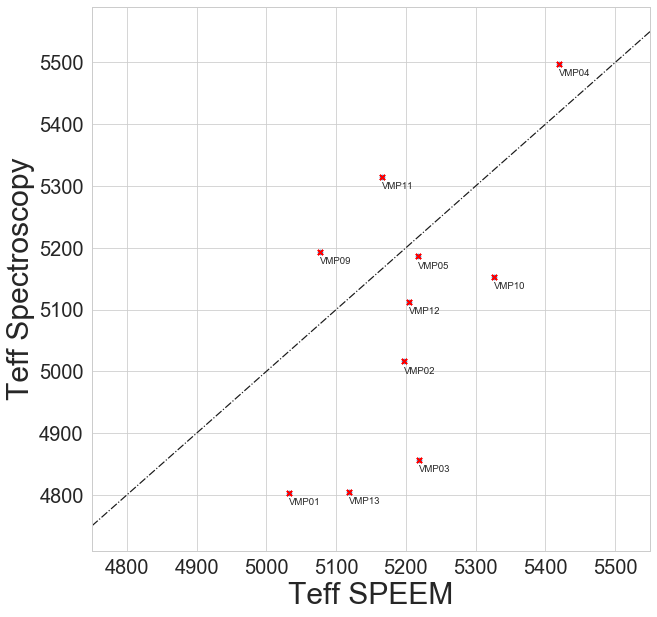

In [41]:
x = Lista['teff_new'].values
y = Lista['teff_spec'].values

x2 = np.arange(4750,5600,50)

types = Lista.reset_index()['NAME'].values

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x, y)
plt.plot(x2,x2,'-.k')

ax.tick_params('both',labelsize=20)
ax.set_xlabel('Teff SPEEM', fontsize=30)
ax.set_ylabel('Teff Spectroscopy', fontsize=30)
#ax.set_title('Teff Photometry vs Spectroscopy', fontsize=28)
ax.set_xlim(4750,5550)
ax.grid(True)

for i, txt in enumerate(types):
    ax.annotate(txt, (x[i], y[i]), xytext=(0,-12), textcoords='offset points')
    plt.scatter(x, y, marker='x', color='red')

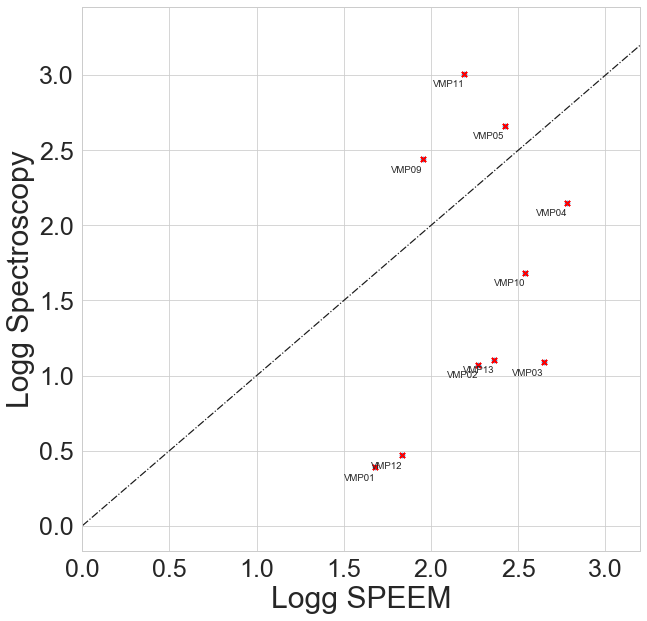

In [42]:
# FeH Photometry vs Spectroscopy
x = Lista['logg_new'].values
y = Lista['logg_spec'].values
#x2 = np.arange(-2.8,-2.19,0.01)
#y2 = (1.5/0.6)*x2+3.5
x2 = np.arange(0.0,3.3,0.01)
#y2 = (1.5/0.6)*x2+3.5


types = Lista.reset_index()['NAME'].values

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x, y)
plt.plot(x2,x2,'-.k')
#ax.scatter(x2,y2,marker='.')

ax.tick_params('both',labelsize=25)
ax.set_xlabel('Logg SPEEM', fontsize=30)
ax.set_ylabel('Logg Spectroscopy', fontsize=30)
#ax.set_title('FeH Photometry vs Spectroscopy', fontsize=28)
ax.set_xlim(0.0,3.2)
ax.grid(True)

for i, txt in enumerate(types):
    ax.annotate(txt, (x[i], y[i]), xytext=(0,-15), textcoords='offset points',ha='right',va='bottom')
    plt.scatter(x, y, marker='x', color='red')

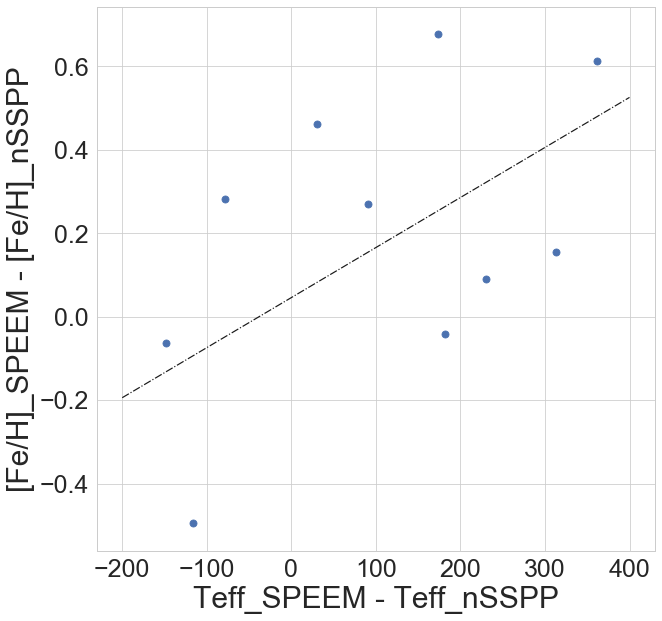

In [61]:
x = Lista['teff_new'].values - Lista['teff_spec'].values
y = Lista['feh_new'].values - Lista['feh_spec'].values

#x2 = np.arange(-0.8, 0.85, 0.05)
x2 = np.arange(-200, 450, 50)
#y2 = 256*x2 + 54.0
#y1 = 0.0023*x2 + 0.0458
y2 = 0.0012*x2 + 0.0458
#y3 = -0.001*x2 + 0.0458


fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x, y, s=50)
#plt.plot(x2, y1,'-.k')
plt.plot(x2, y2,'-.k')
#plt.plot(x2, y3,'-.k')

ax.tick_params('both',labelsize=25)
ax.set_xlabel('Teff_SPEEM - Teff_nSSPP', fontsize=30)
ax.set_ylabel('[Fe/H]_SPEEM - [Fe/H]_nSSPP', fontsize=30)
#ax.set_title('FeH Photometry vs Spectroscopy', fontsize=28)
#ax.set_xlim(-250.0,250.0)
#ax.set_ylim(-1.5, 1.5)
ax.grid(True)

In [58]:
from scipy.stats import linregress, theilslopes

print(linregress(x, y))
print(theilslopes(y, x))

LinregressResult(slope=0.0009774592728440312, intercept=0.09315375940462105, rvalue=0.5002313323592976, pvalue=0.14089989458785848, stderr=0.0005982000089181776)
(0.0012604054942459287, 0.04587079669203645, -0.000620326268814664, 0.0023129199877552757)


In [45]:
Test_SSPP[(Test_SSPP.diff_logg < 0.25) & (Test_SSPP.diff_feh < 0.2) & (Test_SSPP.diff_teff < 100)].describe()

,TEFF_ADOP,FEH_ADOP,LOGG_ADOP,teff_predict,feh_predict,logg_predict,diff_teff,diff_feh,diff_logg
count,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000,1065.000000
mean,6045.490371,-0.775799,3.960181,6055.974609,-0.733085,3.987354,-10.485266,-0.042714,-0.027176
std,666.268083,0.631977,0.385041,673.010620,0.577824,0.304767,57.573188,0.173078,0.215199
min,4777.326700,-3.046659,1.635776,4781.516602,-2.516893,1.418082,-320.943789,-1.166371,-1.820003
25%,5583.074700,-1.093603,3.817070,5590.082031,-0.998713,3.891966,-43.605012,-0.104836,-0.092852
50%,5978.130400,-0.558539,4.016410,5973.861328,-0.535217,4.024083,-5.821598,-0.010343,0.013058
75%,6282.550000,-0.367774,4.207927,6286.894531,-0.347511,4.154445,29.808102,0.069150,0.098268
max,8896.022000,0.296095,4.644985,8913.591797,0.304367,4.698739,99.923246,0.199248,0.249791


In [46]:
Test_SSPP[['diff_teff', 'diff_feh', 'diff_logg']].describe()

,diff_teff,diff_feh,diff_logg
count,1434.000000,1434.000000,1434.000000
mean,4.439509,0.005148,0.020666
std,90.888763,0.231161,0.241716
min,-435.962125,-1.496969,-1.820003
25%,-40.364443,-0.097345,-0.079487
50%,0.155617,0.015127,0.038535
75%,42.708807,0.110531,0.139067
max,1369.001102,1.916650,1.414398


In [47]:
print(np.mean(Test_SSPP[Test_SSPP.LOGG_ADOP < 3.5].diff_logg))
print(np.mean(Test_SSPP[Test_SSPP.LOGG_ADOP > 3.5].diff_logg))

-0.26289686821246344
0.047744734910524105


In [48]:
# Save Model Using joblib
#from sklearn.externals import joblib
import joblib

AstroTools.Path()
MyPath = '/Users/Andres/Documents/PhD/JPLUS_Code/Datasets'
NewPath = '/Users/Andres/Documents/PhD/JPLUS_Code/Models'
AstroTools.ChangeFolder(MyPath,NewPath=NewPath)

filename = 'SPEEM_Multioutput_SSPP.sav'
joblib.dump(Model_FINAL, filename)

Last path:  /Users/Andres/Documents/PhD/JPLUS_Code/Datasets
New path is: /Users/Andres/Documents/PhD/JPLUS_Code/Models


['SPEEM_Multioutput_SSPP.sav']